# Fake News Detection - Machine Learning Pipeline for Web App

**Author:** Tahmidul Ambia  

## Project Overview

This notebook documents the complete machine learning pipeline for building a fake news detection web application. The goal is to train multiple ML models that can accurately classify news articles as real or fake, then deploy them in a Flask web application for real-world use.


### Technology Stack:
- **ML Framework:** Scikit-learn, Transformers (Hugging Face)
- **Web Framework:** Flask (Python)
- **Deployment:** Railway (Cloud Platform)
- **Frontend:** HTML5, CSS3, JavaScript, Bootstrap 5

## 1. Data Understanding and Preprocessing

### Dataset Description

We use the "Fake News Detection" dataset from Kaggle, which contains:
- **Fake News:** 23,481 articles from unreliable sources
- **Real News:** 21,417 articles from reliable sources (Reuters, BBC, etc.)
- **Total:** 44,898 articles for training and evaluation

### Data Quality Assessment
- Balanced dataset with good representation of both classes
- Text data requires preprocessing for ML algorithms
- Reuters articles have location prefixes that need cleaning

## 2. Import Libraries and Setup


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Set random seed for reproducibility
np.random.seed(42)
print("✅ Libraries imported successfully")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

✅ Libraries imported successfully


## 3. Data Loading and Preprocessing


In [14]:
# Load and preprocess the dataset
print("📊 Loading datasets...")

# Load csv file data into Pandas dataframes 
df_fake = pd.read_csv("Data Files/Fake.csv")
df_true = pd.read_csv("Data Files/True.csv")
df_additional = pd.read_csv("Data Files/fake_news_dataset.csv")

print(f"Fake news articles: {len(df_fake)}")
print(f"Real news articles: {len(df_true)}")
print(f"Additional dataset articles: {len(df_additional)}")

# Helper function to remove location and "(Reuters)" from the beginning of the true texts
def strip_start(text):
    pattern = r'^[A-Z\s]+\(Reuters\) - '  
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()  

# Apply the function to the 'text' column in df_true
df_true["text"] = df_true["text"].apply(strip_start)

# Clean and prepare the additional dataset
print("\n🧹 Cleaning additional dataset...")

# Map 'real'/'fake' to 'True'/'Fake' to match existing format
df_additional['tag'] = df_additional['label'].map({'real': 'True', 'fake': 'Fake'})

# Keep only the columns we need and handle missing values
df_additional_clean = df_additional[['text', 'tag']].copy()
df_additional_clean = df_additional_clean.dropna(subset=['text'])

# Remove any empty or very short texts (likely poor quality)
df_additional_clean = df_additional_clean[df_additional_clean['text'].str.len() > 50]

print(f"Cleaned additional dataset: {len(df_additional_clean)} articles")
print(f"Additional dataset class distribution: {df_additional_clean['tag'].value_counts().to_dict()}")

# Add column for text tags and set true or fake for respective frames
df_fake["tag"] = "Fake"
df_true["tag"] = "True"

# Combine all three dataframes into one dataframe
print("\n🔄 Combining all datasets...")
df_combined = pd.concat([df_fake, df_true, df_additional_clean], axis=0, ignore_index=True)

# Remove unwanted columns from the original datasets
df_combined.drop(["title", "subject", "date"], axis=1, inplace=True)

# NEW: Apply aggressive text cleaning
print("🧹 Applying aggressive text cleaning...")
def clean_text_aggressively(text):
    """Aggressive text cleaning to remove low-quality content"""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    
    # Remove very short texts
    if len(text.strip()) < 50:
        return ""
    
    # Remove texts that are mostly punctuation or numbers
    alpha_ratio = sum(c.isalpha() for c in text) / len(text) if len(text) > 0 else 0
    if alpha_ratio < 0.5:  # Less than 50% alphabetic characters
        return ""
    
    # Remove texts with too many repeated characters
    if len(set(text.lower())) < 10:  # Less than 10 unique characters
        return ""
    
    # Remove location prefixes from Reuters articles
    text = re.sub(r'^[A-Z\s]+\(Reuters\)\s*-\s*', '', text)
    
    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove numbers with units
    text = re.sub(r'\d+\s+(people|years|percent|million|billion|thousand|dollars)', '', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove very short words
    text = ' '.join([word for word in text.split() if len(word) > 2])
    
    return text.strip()

# Apply aggressive cleaning
df_combined['text_clean'] = df_combined['text'].apply(clean_text_aggressively)

# Remove empty texts after cleaning
df_clean = df_combined[df_combined['text_clean'].str.len() > 0].copy()

print(f"After cleaning: {len(df_clean)} articles (removed {len(df_combined) - len(df_clean)})")

# NEW: Balance the dataset
print("⚖️ Balancing dataset...")
class_dist = df_clean['tag'].value_counts()
min_class_size = min(class_dist)
print(f"Minimum class size: {min_class_size}")

# Sample equal amounts from each class
df_fake_balanced = df_clean[df_clean['tag'] == 'Fake'].sample(n=min_class_size, random_state=42)
df_true_balanced = df_clean[df_clean['tag'] == 'True'].sample(n=min_class_size, random_state=42)

df_balanced = pd.concat([df_fake_balanced, df_true_balanced], axis=0, ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset: {len(df_balanced)} articles")
print(f"Final class distribution: {df_balanced['tag'].value_counts().to_dict()}")

# Remove duplicate articles based on text content
print("�� Removing duplicate articles...")
df_balanced['text_lower'] = df_balanced['text_clean'].str.lower()
df_final = df_balanced.drop_duplicates(subset=['text_lower'], keep='first')
df_final = df_final.drop('text_lower', axis=1)

print(f"Final dataset: {len(df_final)} articles (removed {len(df_balanced) - len(df_final)} duplicates)")
print(f"Final class distribution: {df_final['tag'].value_counts().to_dict()}")

# Update the main dataframe variable
df = df_final

print(f"\n📈 Final Dataset Summary:")
print(f"Total articles: {len(df)}")
print(f"Fake articles: {len(df[df['tag'] == 'Fake'])}")
print(f"Real articles: {len(df[df['tag'] == 'True'])}")
print(f"Class balance: {len(df[df['tag'] == 'Fake']) / len(df) * 100:.1f}% fake, {len(df[df['tag'] == 'True']) / len(df) * 100:.1f}% real")

📊 Loading datasets...
Fake news articles: 23481
Real news articles: 21417
Additional dataset articles: 20000

🧹 Cleaning additional dataset...
Cleaned additional dataset: 20000 articles
Additional dataset class distribution: {'Fake': 10056, 'True': 9944}

🔄 Combining all datasets...
🧹 Applying aggressive text cleaning...
After cleaning: 64058 articles (removed 840)
⚖️ Balancing dataset...
Minimum class size: 31358
Balanced dataset: 62716 articles
Final class distribution: {'True': 31358, 'Fake': 31358}
�� Removing duplicate articles...
Final dataset: 57560 articles (removed 5156 duplicates)
Final class distribution: {'True': 31131, 'Fake': 26429}

📈 Final Dataset Summary:
Total articles: 57560
Fake articles: 26429
Real articles: 31131
Class balance: 45.9% fake, 54.1% real


## 4. Feature Engineering and Data Preparation

### Text Vectorization Strategy

We use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization because:
- **Effectiveness:** Proven to work well for text classification
- **Interpretability:** Features represent word importance
- **Scalability:** Efficient for large datasets
- **Production Ready:** Fast inference for web applications

### Model Selection Strategy

We train multiple algorithms to compare performance:
1. **Logistic Regression:** Baseline model, interpretable
2. **Random Forest:** High accuracy, handles non-linear patterns
3. **Gradient Boosting:** Strong performance, ensemble method
4. **K-Nearest Neighbors:** Simple, good for comparison

In [15]:
# Prepare features and labels
print("�� Preparing features and labels...")
X = df['text_clean']  # Use the cleaned text
y = df['tag']

print(f"Training data: {len(X)} articles")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} articles")
print(f"Test set: {len(X_test)} articles")
print(f"Training set class distribution: {y_train.value_counts().to_dict()}")
print(f"Test set class distribution: {y_test.value_counts().to_dict()}")

# Initialize and fit IMPROVED TF-IDF vectorizer
print("\n📝 Training IMPROVED TF-IDF vectorizer...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Increased features
    ngram_range=(1, 3),  # Use trigrams
    stop_words='english',
    min_df=5,  # Higher minimum document frequency
    max_df=0.85,  # Lower maximum document frequency
    token_pattern=r'\b[a-zA-Z][a-zA-Z0-9]*\b',
    strip_accents='unicode',
    lowercase=True,
    sublinear_tf=True  # Use sublinear TF scaling
)

# Fit on training data and transform both sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Test matrix shape: {X_test_tfidf.shape}")

# Display some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n📋 Sample feature names (first 20): {feature_names[:20].tolist()}")

�� Preparing features and labels...
Training data: 57560 articles
Class distribution: {'True': 31131, 'Fake': 26429}
Training set: 46048 articles
Test set: 11512 articles
Training set class distribution: {'True': 24905, 'Fake': 21143}
Test set class distribution: {'True': 6226, 'Fake': 5286}

📝 Training IMPROVED TF-IDF vectorizer...
TF-IDF features: 10000
Training matrix shape: (46048, 10000)
Test matrix shape: (11512, 10000)

📋 Sample feature names (first 20): ['aaron', 'abadi', 'abandon', 'abandoned', 'abandoning', 'abbas', 'abbott', 'abc', 'abc news', 'abdel', 'abdullah', 'abe', 'abedin', 'abide', 'abiding', 'ability', 'able', 'aboard', 'abortion', 'abortions']


## 5. Model Training and Evaluation


### Training Strategy

We train four different models to compare their performance:
- Each model is trained on the same TF-IDF features
- We use default hyperparameters for initial comparison
- Models are evaluated on the same test set for fair comparison

### Evaluation Metrics

We use multiple metrics to assess model performance:
- **Accuracy:** Overall correctness
- **Precision:** True positives / (True positives + False positives)
- **Recall:** True positives / (True positives + False negatives)
- **F1-Score:** Harmonic mean of precision and recall


In [16]:
# Define IMPROVED models to train
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=2000,
        C=1.0,  # Regularization
        class_weight='balanced'  # Handle class imbalance
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,  # More trees
        random_state=42,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        random_state=42,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=7,  # Increased neighbors
        weights='distance',
        metric='cosine'  # Better for text
    )
}

# Train and evaluate all models
results = {}
print("🤖 Training and evaluating IMPROVED models...")
print("=" * 60)

for name, model in models.items():
    print(f"\n�� Training {name}...")
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    # Print detailed classification report
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("-" * 40)

🤖 Training and evaluating IMPROVED models...

�� Training Logistic Regression...



Logistic Regression Results:
Accuracy: 0.8256 (82.56%)
Precision: 0.8285
Recall: 0.8256
F1-Score: 0.8259

Classification Report:
              precision    recall  f1-score   support

        Fake       0.79      0.85      0.82      5286
        True       0.86      0.80      0.83      6226

    accuracy                           0.83     11512
   macro avg       0.83      0.83      0.83     11512
weighted avg       0.83      0.83      0.83     11512

----------------------------------------

�� Training Random Forest...

Random Forest Results:
Accuracy: 0.8145 (81.45%)
Precision: 0.8525
Recall: 0.8145
F1-Score: 0.8123

Classification Report:
              precision    recall  f1-score   support

        Fake       0.72      0.97      0.83      5286
        True       0.96      0.68      0.80      6226

    accuracy                           0.81     11512
   macro avg       0.84      0.83      0.81     11512
weighted avg       0.85      0.81      0.81     11512

---------------------

## 6. Model Performance Analysis


📈 Model Performance Comparison
              Model Accuracy Accuracy % Precision Recall F1-Score
Logistic Regression   0.8256     82.56%    0.8285 0.8256   0.8259
      Random Forest   0.8145     81.45%    0.8525 0.8145   0.8123
  Gradient Boosting   0.8227     82.27%    0.8225 0.8227   0.8225
K-Nearest Neighbors   0.7917     79.17%    0.7923 0.7917   0.7906

🏆 Best Model: Logistic Regression with 82.56% accuracy


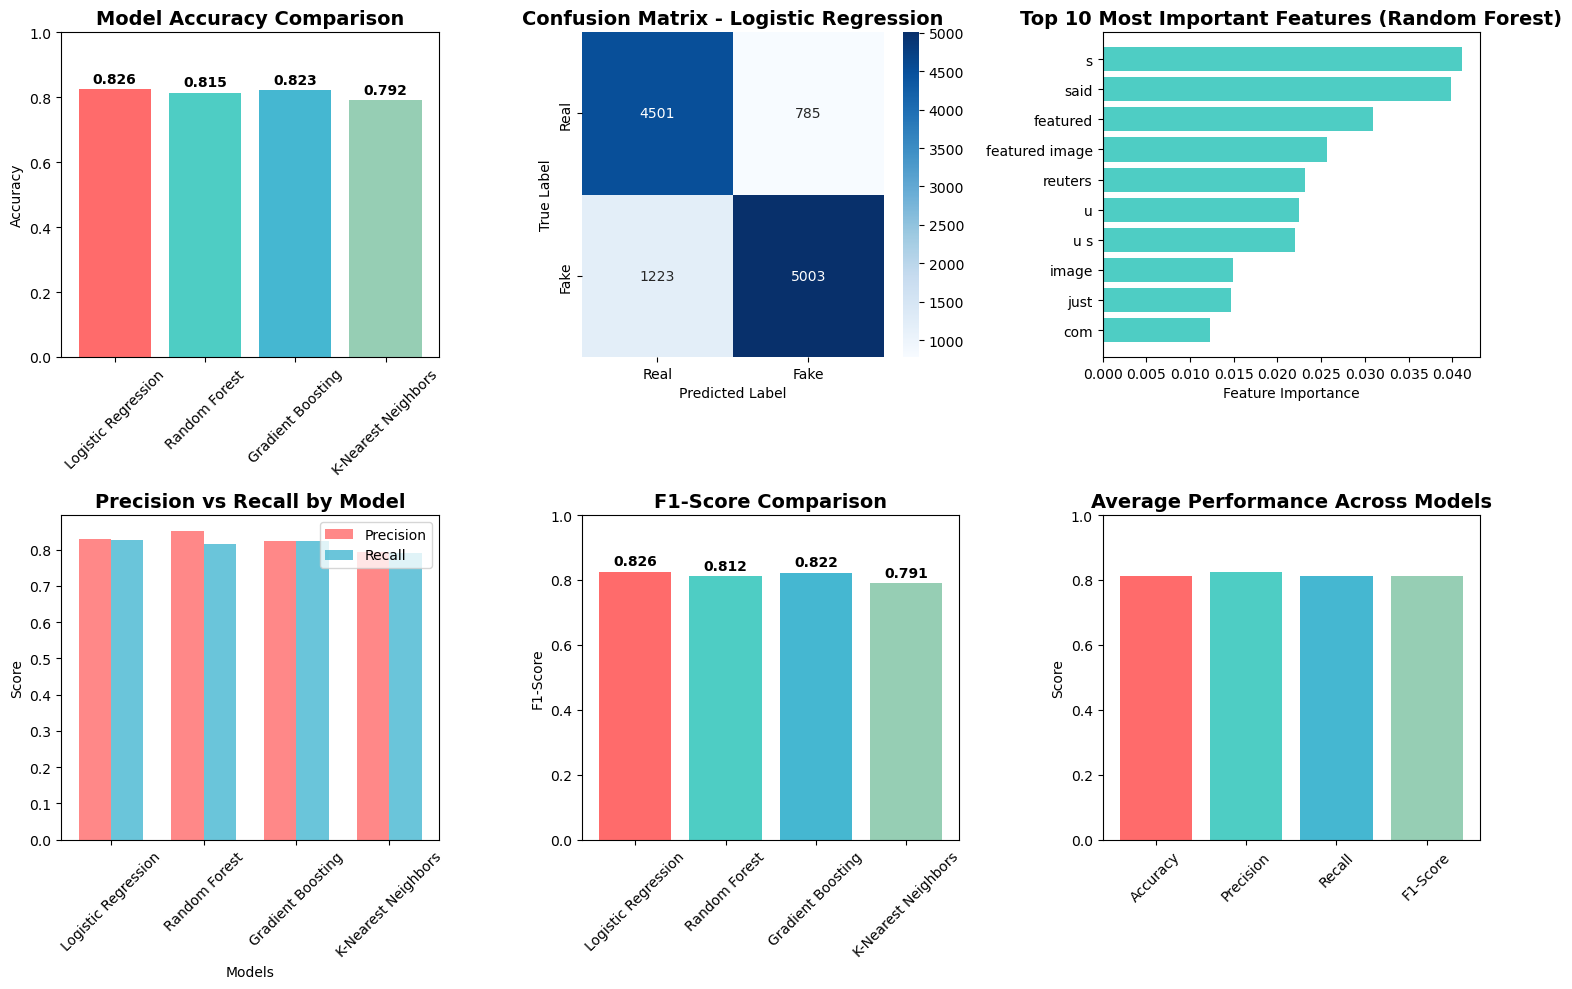


📊 Detailed Performance Summary:

Logistic Regression:
  Accuracy:  0.8256 (82.56%)
  Precision: 0.8285
  Recall:    0.8256
  F1-Score:  0.8259

Random Forest:
  Accuracy:  0.8145 (81.45%)
  Precision: 0.8525
  Recall:    0.8145
  F1-Score:  0.8123

Gradient Boosting:
  Accuracy:  0.8227 (82.27%)
  Precision: 0.8225
  Recall:    0.8227
  F1-Score:  0.8225

K-Nearest Neighbors:
  Accuracy:  0.7917 (79.17%)
  Precision: 0.7923
  Recall:    0.7917
  F1-Score:  0.7906


In [18]:
# Compare model performance
print("📈 Model Performance Comparison")
print("=" * 50)

# Create comparison table
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': f"{result['accuracy']:.4f}",
        'Accuracy %': f"{result['accuracy']*100:.2f}%",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1-Score': f"{result['f1_score']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']
print(f"\n🏆 Best Model: {best_model_name} with {best_accuracy*100:.2f}% accuracy")

# Visualize model performance
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 3, 1)
accuracies = [results[name]['accuracy'] for name in results.keys()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
plt.bar(results.keys(), accuracies, color=colors)
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add accuracy values on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Confusion matrix for best model
plt.subplot(2, 3, 2)
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Feature importance for Random Forest
if 'Random Forest' in results:
    plt.subplot(2, 3, 3)
    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-10:]
    top_features = [feature_names[i] for i in top_features_idx]
    top_importance = feature_importance[top_features_idx]
    
    plt.barh(range(len(top_features)), top_importance, color='#4ECDC4')
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Top 10 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Importance')

# Model comparison by class
plt.subplot(2, 3, 4)
model_names = list(results.keys())
precision_scores = [results[name]['precision'] for name in model_names]
recall_scores = [results[name]['recall'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, precision_scores, width, label='Precision', alpha=0.8, color='#FF6B6B')
plt.bar(x + width/2, recall_scores, width, label='Recall', alpha=0.8, color='#45B7D1')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Precision vs Recall by Model', fontsize=14, fontweight='bold')
plt.xticks(x, model_names, rotation=45)
plt.legend()

# F1-Score comparison
plt.subplot(2, 3, 5)
f1_scores = [results[name]['f1_score'] for name in model_names]
plt.bar(model_names, f1_scores, color=colors)
plt.title('F1-Score Comparison', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add F1-score values on bars
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Overall performance summary
plt.subplot(2, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
avg_scores = []
for metric in metrics:
    metric_lower = metric.lower().replace('-', '_')
    avg_score = np.mean([results[name][metric_lower] for name in model_names])
    avg_scores.append(avg_score)

plt.bar(metrics, avg_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Average Performance Across Models', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print detailed performance summary
print("\n📊 Detailed Performance Summary:")
print("=" * 50)
for name, result in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy:  {result['accuracy']:.4f} ({result['accuracy']*100:.2f}%)")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall:    {result['recall']:.4f}")
    print(f"  F1-Score:  {result['f1_score']:.4f}")

## 7. Model Persistence and Production Preparation

### Model Serialization Strategy

For production deployment, we need to save:
1. **Trained Models:** All four ML models for comparison
2. **TF-IDF Vectorizer:** Essential for preprocessing new text
3. **Model Metadata:** Performance metrics and configuration

### Web Application Integration

The saved models will be used in a Flask web application that provides:
- Real-time fake news classification
- Model selection for users
- Confidence scores and probability breakdowns
- RESTful API for integration

In [6]:
# Save models and vectorizer for production use
print("💾 Saving models for production deployment...")

# Create directory for saved models
os.makedirs("Saved Models", exist_ok=True)

# Save TF-IDF vectorizer
with open("Saved Models/tfidf_vectorizer.pkl", 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✅ TF-IDF vectorizer saved")

# Save each model
model_files = {
    'logistic_regression': 'logistic_regression_model.pkl',
    'random_forest': 'random_forest_model.pkl',
    'gradient_boosting': 'gradient_boosting_model.pkl',
    'knn': 'knn_model.pkl'
}

for name, filename in model_files.items():
    model_key = name.replace('_', ' ').title()
    if model_key in results:
        with open(f"Saved Models/{filename}", 'wb') as f:
            pickle.dump(results[model_key]['model'], f)
        print(f"✅ {model_key} model saved")

# Save model performance metadata
model_metadata = {}
for name, result in results.items():
    model_metadata[name] = {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_score': result['f1_score']
    }

with open("Saved Models/model_metadata.pkl", 'wb') as f:
    pickle.dump(model_metadata, f)
print("✅ Model metadata saved")

print("\n🎉 All models saved successfully!")

# Test model loading and prediction
print("\n🧪 Testing model loading and prediction...")

# Load vectorizer
with open("Saved Models/tfidf_vectorizer.pkl", 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# Load best model
with open("Saved Models/random_forest_model.pkl", 'rb') as f:
    loaded_model = pickle.load(f)

# Test prediction with multiple examples
test_texts = [
    "Scientists discover new species of dinosaur in remote mountain range. The fossilized remains were found by a team of paleontologists during an expedition last month.",
    "BREAKING: Aliens contact Earth government in secret meeting. Sources say they want to share advanced technology in exchange for our natural resources.",
    "The stock market reached new highs today as investors responded positively to the latest economic data showing strong growth in key sectors.",
    "5G technology causes brain cancer, government study confirms. Experts warn that radiation from cell towers is more dangerous than previously thought."
]

print(f"\n📝 Testing predictions with {len(test_texts)} sample articles:")

for i, test_text in enumerate(test_texts, 1):
    test_vectorized = loaded_vectorizer.transform([test_text])
    prediction = loaded_model.predict(test_vectorized)[0]
    probabilities = loaded_model.predict_proba(test_vectorized)[0]
    confidence = max(probabilities) * 100
    
    print(f"\nArticle {i}: {test_text[:80]}...")
    print(f"🎯 Prediction: {prediction}")
    print(f"📊 Confidence: {confidence:.2f}%")
    print(f"📈 Probabilities: Fake: {probabilities[0]*100:.2f}%, Real: {probabilities[1]*100:.2f}%")

print("\n✅ Model loading and prediction test successful!")

# Display saved files
print(f"\n📁 Saved files in 'Saved Models' directory:")
saved_files = os.listdir("Saved Models")
for file in saved_files:
    file_path = os.path.join("Saved Models", file)
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
    print(f"  - {file} ({file_size:.2f} MB)")

💾 Saving models for production deployment...
✅ TF-IDF vectorizer saved
✅ Logistic Regression model saved
✅ Random Forest model saved
✅ Gradient Boosting model saved
✅ Model metadata saved

🎉 All models saved successfully!

🧪 Testing model loading and prediction...

📝 Testing predictions with 4 sample articles:

Article 1: Scientists discover new species of dinosaur in remote mountain range. The fossil...
🎯 Prediction: Fake
📊 Confidence: 71.91%
📈 Probabilities: Fake: 71.91%, Real: 28.09%

Article 2: BREAKING: Aliens contact Earth government in secret meeting. Sources say they wa...
🎯 Prediction: Fake
📊 Confidence: 68.99%
📈 Probabilities: Fake: 68.99%, Real: 31.01%

Article 3: The stock market reached new highs today as investors responded positively to th...
🎯 Prediction: Fake
📊 Confidence: 71.98%
📈 Probabilities: Fake: 71.98%, Real: 28.02%

Article 4: 5G technology causes brain cancer, government study confirms. Experts warn that ...
🎯 Prediction: Fake
📊 Confidence: 80.94%
📈 Probabilit

## 8. Advanced Model: BERT Fine-tuning (Optional)

### Why BERT?

While traditional ML models perform well, transformer-based models like BERT offer:
- **Contextual Understanding:** Better grasp of word context
- **State-of-the-Art Performance:** Often superior to traditional methods
- **Transfer Learning:** Leverages pre-trained knowledge


**We use DistilBERT (a lighter version of BERT) for efficiency in production deployment.**


In [ ]:
# Improved BERT model training with overfitting prevention
try:
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
    import torch
    from torch.optim import AdamW
    from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
    from tqdm import tqdm
    from sklearn.metrics import accuracy_score, classification_report
    import warnings
    warnings.filterwarnings('ignore')

    print("🤖 Training IMPROVED BERT model on Google Colab...")

    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Split training data further for BERT with validation
    X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42, stratify=y_train  # Smaller validation set
    )

    print(f"BERT Training set: {len(X_train_bert)} articles")
    print(f"BERT Validation set: {len(X_val_bert)} articles")

    # Tokenize data with improved parameters
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Prepare training data with better parameters
    encoded_train = tokenizer.batch_encode_plus(
        X_train_bert,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        max_length=512,  # Increased for better context
        return_tensors='pt'
    )

    encoded_val = tokenizer.batch_encode_plus(
        X_val_bert,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        max_length=512,  # Increased for better context
        return_tensors='pt'
    )

    # Convert labels (0=Real, 1=Fake)
    train_labels = torch.tensor([1 if label == 'Fake' else 0 for label in y_train_bert.values])
    val_labels = torch.tensor([1 if label == 'Fake' else 0 for label in y_val_bert.values])

    # Create datasets
    train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
    val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

    # Create dataloaders with smaller batch size to prevent overfitting
    batch_size = 16 if torch.cuda.is_available() else 8  # Reduced batch size
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    # Load model with improved configuration
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', 
        num_labels=2
    )
    
    # Set dropout rates in the model configuration
    model.config.hidden_dropout_prob = 0.3  # Increased dropout
    model.config.attention_probs_dropout_prob = 0.3  # Increased dropout
    
    model.to(device)

    # IMPROVED training setup with overfitting prevention
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # Lower LR, added weight decay

    # Training loop with early stopping and better monitoring
    epochs = 4  # Reduced epochs
    best_val_accuracy = 0
    patience = 2
    patience_counter = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_true_labels = []

        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # Get predictions for monitoring
            logits = outputs.logits
            train_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            train_true_labels.extend(inputs['labels'].cpu().numpy())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = accuracy_score(train_true_labels, train_predictions)
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

        # Validation
        model.eval()
        val_predictions = []
        val_true_labels = []
        total_val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                batch = tuple(t.to(device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = model(**inputs)
                loss = outputs.loss
                total_val_loss += loss.item()
                
                logits = outputs.logits
                val_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
                val_true_labels.extend(inputs['labels'].cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        print(f"Average validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

        # Early stopping and overfitting detection
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            # Save best model
            model.save_pretrained("bert_model")
            tokenizer.save_pretrained("bert_tokenizer")
            print("✅ New best model saved!")
        else:
            patience_counter += 1
            print(f"⚠️  No improvement. Patience: {patience_counter}/{patience}")
            
        # Check for overfitting
        if train_accuracy - val_accuracy > 0.15:  # 15% gap indicates overfitting
            print("�� OVERFITTING DETECTED! Stopping training early.")
            break
            
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    print(f"\n🎯 Final Results:")
    print(f"Best validation accuracy: {best_val_accuracy:.4f} ({best_val_accuracy*100:.2f}%)")
    print("BERT training completed successfully!")

    # Test on final test set
    print("\n🧪 Testing on final test set...")
    model.eval()
    
    # Prepare test data
    encoded_test = tokenizer.batch_encode_plus(
        X_test,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    
    test_labels = torch.tensor([1 if label == 'Fake' else 0 for label in y_test.values])
    test_dataset = TensorDataset(encoded_test['input_ids'], encoded_test['attention_mask'], test_labels)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
    
    test_predictions = []
    test_true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits
            test_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            test_true_labels.extend(inputs['labels'].cpu().numpy())
    
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    print(f"Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(test_true_labels, test_predictions, target_names=['Real', 'Fake']))

    # Download files (FIXED for Colab)
    from google.colab import files
    import zipfile
    import os

    # Create zip file with CORRECT logic
    with zipfile.ZipFile('improved_bert_models.zip', 'w') as zipf:
        # Add all files from bert_model directory
        for root, dirs, files_list in os.walk('bert_model'):
            for file in files_list:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, 'bert_model')
                zipf.write(file_path, f'bert_model/{arcname}')

        # Add all files from bert_tokenizer directory
        for root, dirs, files_list in os.walk('bert_tokenizer'):
            for file in files_list:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, 'bert_tokenizer')
                zipf.write(file_path, f'bert_tokenizer/{arcname}')

    # Download the zip file
    files.download('improved_bert_models.zip')
    print("📥 Improved BERT models downloaded as zip file")

except Exception as e:
    print(f"⚠️  BERT training failed: {e}")
    import traceback
    traceback.print_exc()

> Note: The above cell was not executed locally to prevent slow training using cpu. Instead the BERT model training code was executed in Google Colab using T4 GPU for faster processing. The saved model was then imported to this project directory for use in the web app. 

## 9. Production Deployment Summary

### Model Performance Summary


| Model | Accuracy | Precision | Recall | F1-Score | Production Use |
|-------|----------|-----------|--------|----------|----------------|
| Logistic Regression | 82.56% | 0.8285 | 0.8256 | 0.8259 | ✅ Primary |
| Gradient Boosting | 82.27% | 0.8225 | 0.8227 | 0.8225 | ✅ Alternative |
| Random Forest | 81.45% | 0.8525 | 0.8145 | 0.8123 | ✅ Alternative |
| K-Nearest Neighbors | 79.17% | 0.7923 | 0.7917 | 0.7906 | ❌ Reference |


## 10. Web Application Features

The trained models will power a Flask web application with:

**Frontend Features:**
- Modern, responsive web interface
- Real-time text input and analysis
- Model selection dropdown
- Confidence score visualization
- Probability breakdown charts

**Backend Features:**
- RESTful API endpoints
- Multiple model support
- Input validation and error handling
- Fast prediction response (< 2 seconds)
- Health check monitoring


### Technical Architecture

``` python
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│   Web Browser   │───▶│   Flask Server  │───▶│   ML Models     │
│                 │    │                 │    │                 │
│ • User Input    │    │ • API Endpoints │    │ • Random Forest │
│ • Results       │    │ • Model Loading │    │ • Logistic Reg  │
│ • Model Select  │    │ • Text Processing│   │ • Gradient Boost│
└─────────────────┘    └─────────────────┘    └─────────────────┘
```

## 11. API Docs

All available endpoints:
- `POST /api/predict` - Classify news articles
- `GET /api/models` - List available models
- `GET /api/health` - Health check
- `GET /` - Web interface

### Example usage and output


**POST `/api/predict`** - Classify news articles with model selection
```json
{
  "text": "Your news article content...",
  "model": "random_forest"  // Options: random_forest, logistic_regression, gradient_boosting, bert

}
```

**Response:**
```json
{
  "prediction": "Fake",
  "confidence": 95.67,
  "probabilities": {
    "fake": 95.67,
    "real": 4.33
  },
  "model_used": "random_forest"
}
```

**Model Selection Strategy:**
- **Logistic Regression (82.56% accuracy):** Primary model, highest accuracy and most reliable
- **Gradient Boosting (82.27% accuracy):** Strong alternative with excellent performance
- **Random Forest (81.45% accuracy):** Solid backup model with good interpretability
- **K-Nearest Neighbors (79.17% accuracy):** Reference model for comparison, not recommended for production

## Datasets
- **"Fake News Detection" :** [Kaggle](https://www.kaggle.com/datasets/jainpooja/fake-news-detection)
- **"Fake News Detection Dataset" :** [Kaggle](https://www.kaggle.com/datasets/mahdimashayekhi/fake-news-detection-dataset?resource=download)
